In [1]:
import os
import sys
import json
sys.path.insert(0, os.path.abspath('../'))
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-10 15:59:04.079430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 15:59:04.541026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-10 15:59:05.116301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:05.139355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:05.139398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SHIFT_WIDTH = 40
REG_JUMP = 2

In [3]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 256
PATIENCE = 100
NB_FEATURES = 2

In [4]:
loaded = np.load(f'./training_data/training_set_{SHIFT_WIDTH}_{REG_JUMP}.npz')
input_signals = loaded['input_signals']
input_labels = loaded['input_labels']
input_reg_signals = loaded['input_reg_signals']
input_reg_labels = loaded['input_reg_labels']
count_0 = loaded['count_0']
count_1 = loaded['count_1']
class_weight = loaded['class_weight']
class_weight = {0: class_weight[0], 1:class_weight[1]}

INPUT_CLS_SHAPE = [-1, 1, input_signals.shape[-1], 1]
INPUT_REG_SHAPE = [-1, 1, input_reg_signals.shape[-1], 1]

print(input_signals.shape, input_labels.shape)
print(input_reg_signals.shape, input_reg_labels.shape)
print(class_weight, count_0, count_1)
print(INPUT_CLS_SHAPE, INPUT_REG_SHAPE)

(127538, 42) (127538,)
(465867, 40) (465867,)
{0: 0.8011482844830836, 1: 1.330155816524478} 79597 47941
[-1, 1, 42, 1] [-1, 1, 40, 1]


In [5]:
input_signals = input_signals.reshape(INPUT_CLS_SHAPE)
input_labels = input_labels.reshape(-1, 1)
input_reg_signals = input_reg_signals.reshape(INPUT_REG_SHAPE)
input_reg_labels = input_reg_labels.reshape(-1, 1)

train_input = []
train_label = []
val_input = []
val_label = []
cur_count_0 = 0
cur_count_1 = 0
for i in range(len(input_labels)):
    if input_labels[i] == 0:
        cur_count_0 += 1
        if cur_count_0 < int(count_0 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
    else:
        cur_count_1 += 1
        if cur_count_1 < int(count_1 * 0.8):
            train_input.append(input_signals[i])
            train_label.append(input_labels[i])
        else:
            val_input.append(input_signals[i])
            val_label.append(input_labels[i])
            
train_input = np.array(train_input)
train_label = np.array(train_label)
val_input = np.array(val_input)
val_label = np.array(val_label)

train_reg_input = input_reg_signals[:int(input_reg_signals.shape[0] * 0.8)]
val_reg_input = input_reg_signals[int(input_reg_signals.shape[0] * 0.8):]
train_reg_label = input_reg_labels[:int(input_reg_labels.shape[0] * 0.8)]
val_reg_label = input_reg_labels[int(input_reg_labels.shape[0] * 0.8):]

In [6]:
def shuffle(data, label):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    data = data[shuffle_index]
    label = label[shuffle_index]
    return data, label

In [7]:
train_input, train_label = shuffle(train_input, train_label)
val_input, val_label = shuffle(val_input, val_label)
train_reg_input, train_reg_label = shuffle(train_reg_input, train_reg_label)
val_reg_input, val_reg_label = shuffle(val_reg_input, val_reg_label)

In [8]:
print(f'train_cls_shape:{train_input.shape}\n',
      f'val_cls_shape:{val_input.shape}\n',
      f'train_reg_shape:{train_reg_input.shape}\n',
      f'val_reg_shape:{val_reg_input.shape}\n'
     )

train_cls_shape:(102027, 1, 42, 1)
 val_cls_shape:(25511, 1, 42, 1)
 train_reg_shape:(372693, 1, 40, 1)
 val_reg_shape:(93174, 1, 40, 1)



In [9]:
@tf.keras.utils.register_keras_serializable('JSC')
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [10]:
"""
regression_model = Anomalous_regression()
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                             metrics=[tf.keras.metrics.MeanAbsoluteError(
                                 name='mean_absolute_error', dtype=None)]
                        ) 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )
    
history = regression_model.fit(x=train_reg_tf,
                                   validation_data=val_reg_tf,
                                   epochs=MAX_EPOCHS,
                                   shuffle=True,
                                   callbacks=[early_stopping],
                                   verbose=2
                                  )
regression_model.save('regression_model_.keras')
"""

"\nregression_model = Anomalous_regression()\nregression_model.compile(loss=tf.keras.losses.MeanSquaredError(),\n                             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),\n                             metrics=[tf.keras.metrics.MeanAbsoluteError(\n                                 name='mean_absolute_error', dtype=None)]\n                        ) \nearly_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',\n                                                  patience=PATIENCE,\n                                                  mode='min',\n                                                  restore_best_weights=True,\n                                                 )\n    \nhistory = regression_model.fit(x=train_reg_tf,\n                                   validation_data=val_reg_tf,\n                                   epochs=MAX_EPOCHS,\n                                   shuffle=True,\n                                   callbacks=[early_stopping],\n  

In [10]:
train_input_signal = train_input[:,:,:-NB_FEATURES,:]
train_input_features = train_input[:,:,-NB_FEATURES:,:].reshape(-1, NB_FEATURES)
val_input_signal = val_input[:,:,:-NB_FEATURES,:]
val_input_features = val_input[:,:,-NB_FEATURES:,:].reshape(-1, NB_FEATURES)

print(f'signal_shape:{train_input_signal.shape}\n',
      f'feature_shape:{train_input_features.shape}\n',
     )

signal_shape:(102027, 1, 40, 1)
 feature_shape:(102027, 2)



In [11]:
signal_input = keras.Input(shape=train_input_signal.shape[1:], name="signal")
feature_input = keras.Input(shape=(NB_FEATURES,), name="features")

x1 = layers.Flatten()(signal_input)
x1 = layers.Dense(units=1)(x1)
x1 = layers.ReLU()(x1)

x2 = layers.Dense(units=2)(feature_input)
x2 = layers.ReLU()(x2)
cls_concat = layers.concatenate([x1, x2])
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_concat)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)

2024-05-10 15:59:09.683944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:09.684014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:09.684043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:09.810282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:59:09.810327: I external/local_xla/xla/stream_executor

In [11]:
"""
signal_input = keras.Input(shape=train_input_signal.shape[1:], name="signal")
feature_input = keras.Input(shape=(NB_FEATURES,), name="features")

x1 = layers.ConvLSTM1D(filters=128, kernel_size=2, strides=1, padding='same', dropout=0.1)(signal_input)
x1 = layers.ReLU()(x1)
x1 = layers.Bidirectional(layers.LSTM(32))(x1)
x1 = layers.ReLU()(x1)
x1 =  layers.Flatten()(x1)

x2 = layers.Dense(units=32)(feature_input)
x2 = layers.ReLU()(x2)
x2 = layers.Dense(units=32)(x2)
x2 = layers.ReLU()(x2)
cls_concat = layers.concatenate([x1, x2])
cls_last_layer = layers.Dense(units=1, activation='sigmoid')(cls_concat)

cls_model = keras.Model(
    inputs=[signal_input, feature_input],
    outputs=[cls_last_layer],
    name='anomalous_detection'
)
"""

2024-05-10 15:29:41.276768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:29:41.276830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:29:41.276855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:29:41.403462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 15:29:41.403507: I external/local_xla/xla/stream_executor

In [12]:
cls_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='Acc'),
                           Jaccard(name='JSC', dtype=None)]
                 )
cls_model.build(input_shape=INPUT_CLS_SHAPE[1:])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=PATIENCE,
                                                  mode='min',
                                                  restore_best_weights=True,
                                                 )

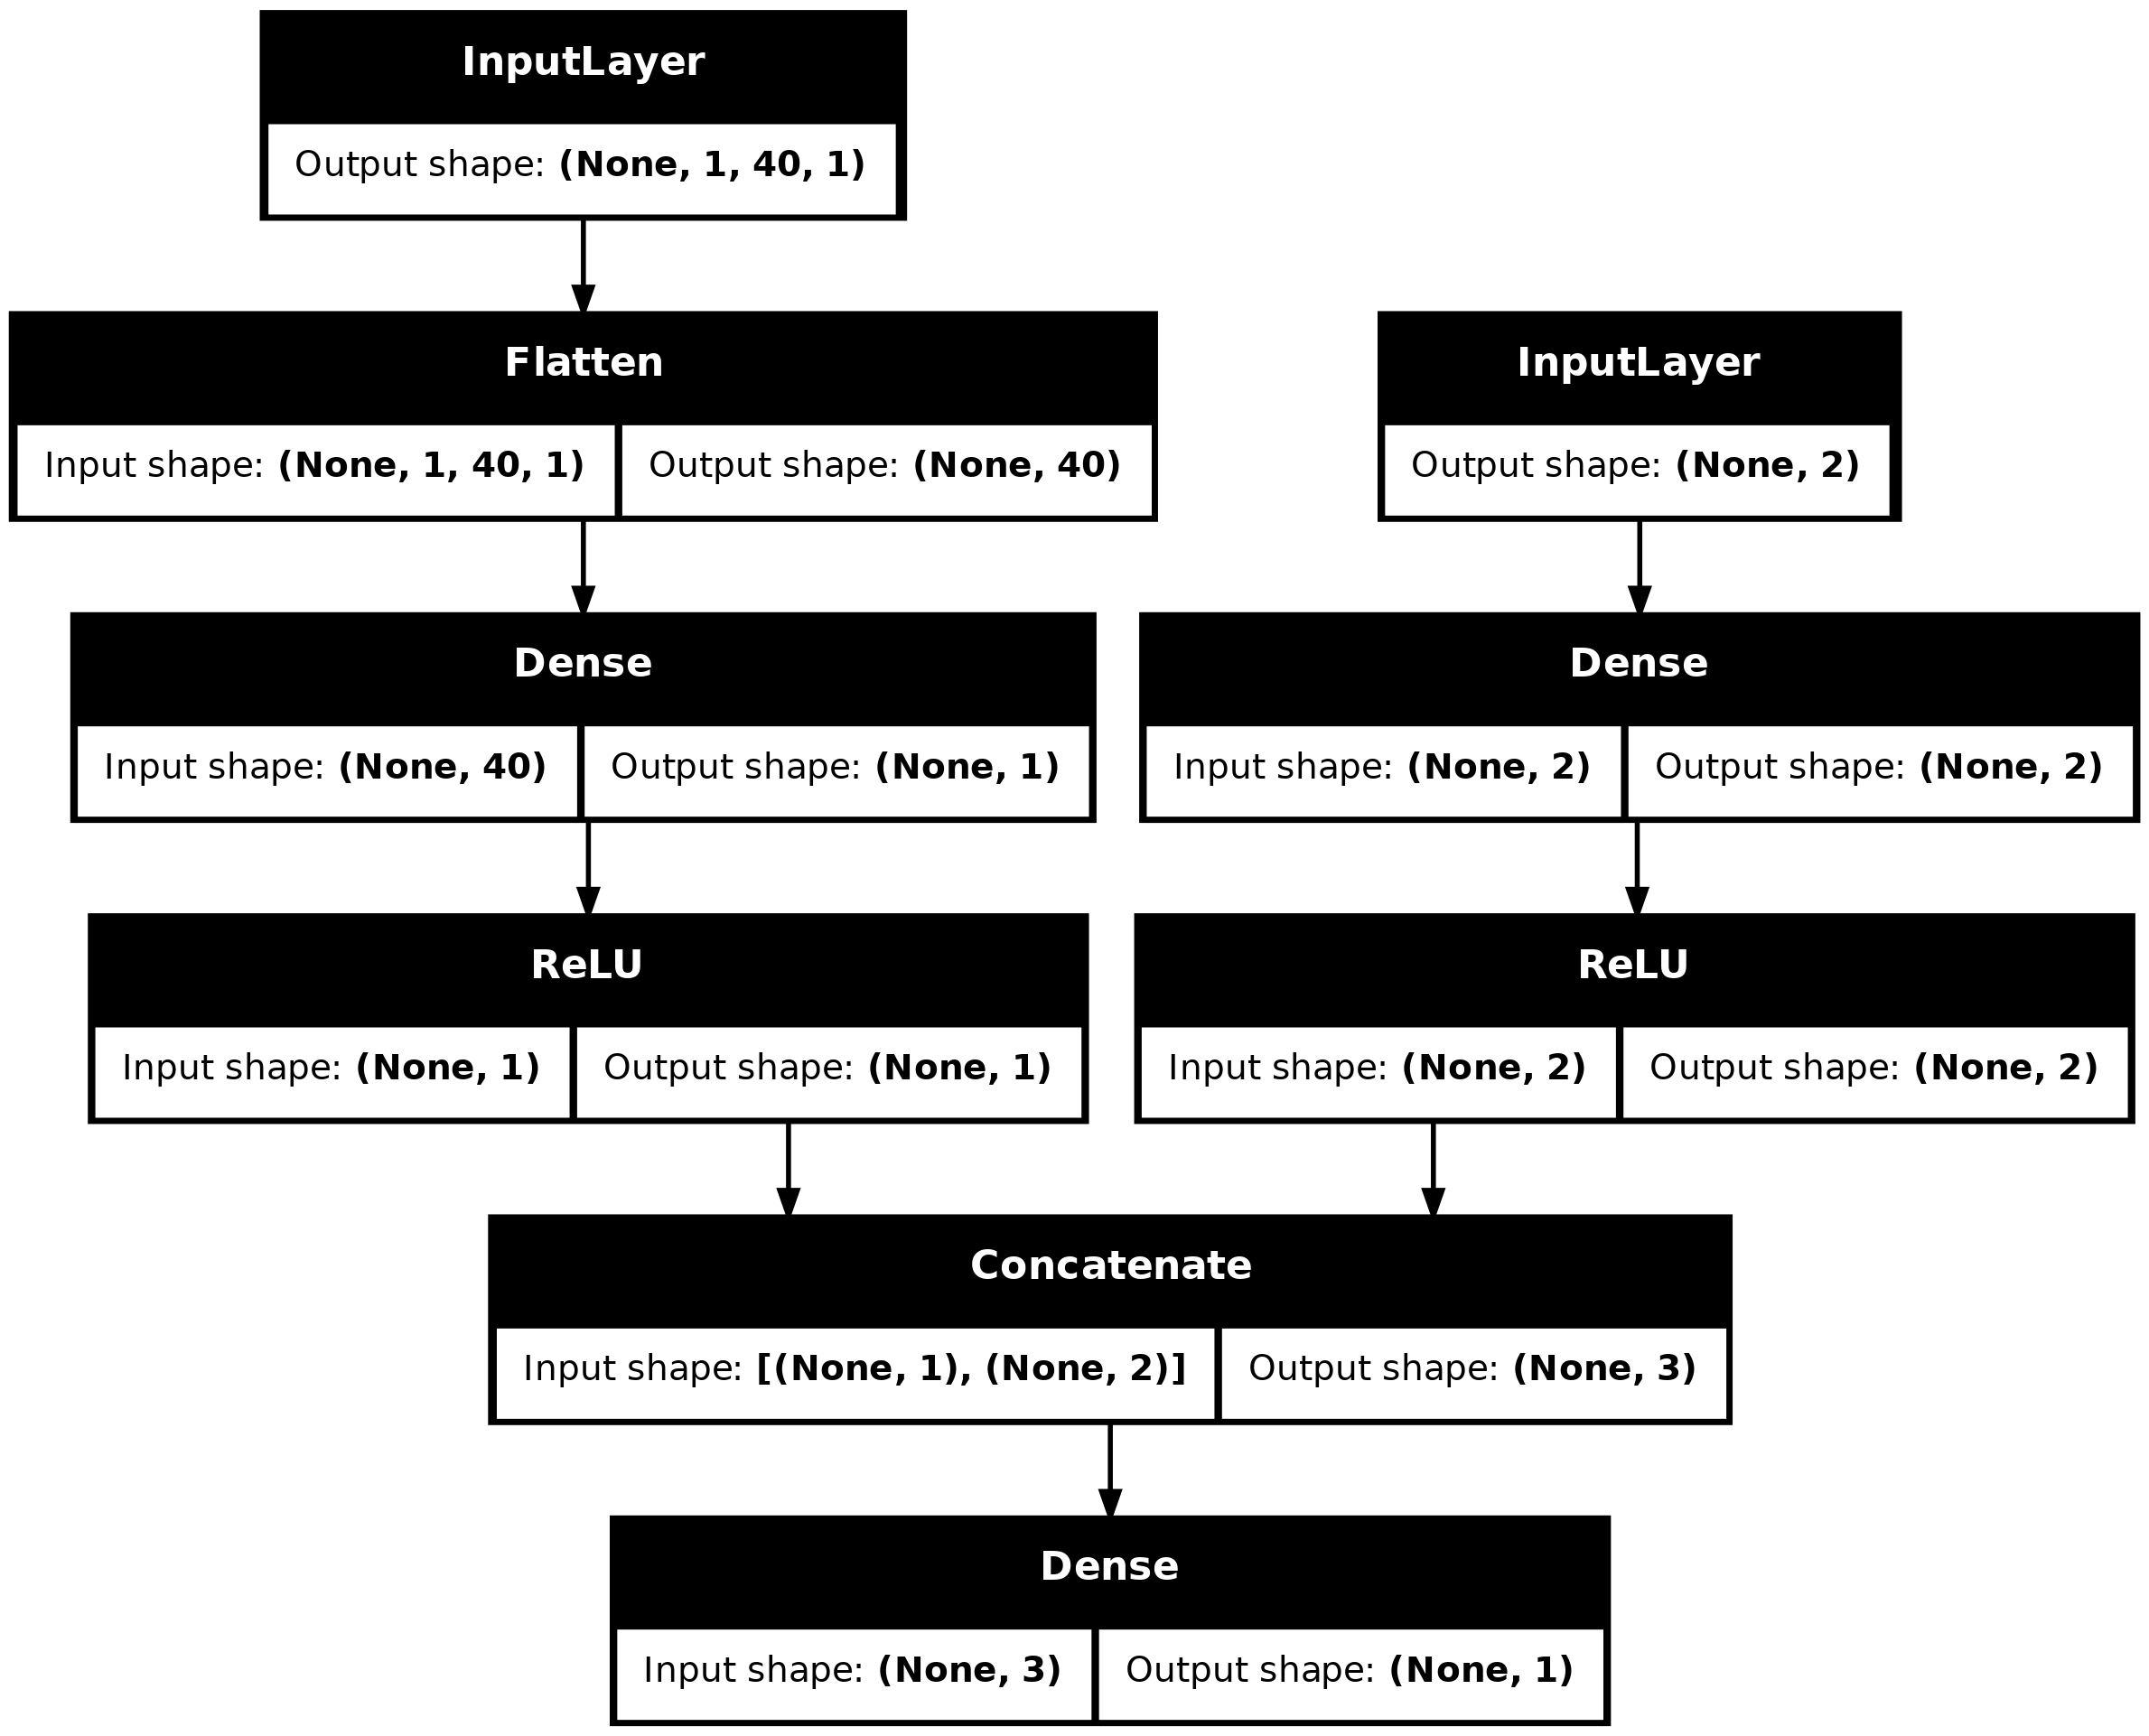

In [13]:
keras.utils.plot_model(cls_model, "cls_model.png", show_shapes=True)

In [14]:
cls_model.summary()

Model: "anomalous_detection"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 1, 40, 1)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 40)        │          0 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         41 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │          6 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 1)         │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 2)         │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ re_lu[0][0],      │
│ (Concatenate)       │                   │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          4 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
cls_history = cls_model.fit(x=[train_input_signal, train_input_features],
                        y=train_label,
                        validation_data=([val_input_signal, val_input_features], val_label),
                        batch_size=BATCH_SIZE,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        callbacks=[early_stopping],
                        class_weight=class_weight,
                        verbose=2
                       )
cls_model.save(f'./models/cls_model_{SHIFT_WIDTH}_{REG_JUMP}.keras')
history_dict = cls_history.history
json.dump(history_dict, open(f'./models/history_{SHIFT_WIDTH}_{REG_JUMP}.json', 'w'))

Epoch 1/10000


I0000 00:00:1715349559.825394   86466 service.cc:145] XLA service 0x7f0c1c005110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715349559.825429   86466 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-10 15:59:19.839832: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 15:59:19.916067: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715349560.332161   86466 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


399/399 - 2s - 6ms/step - Acc: 0.5950 - JSC: 0.4016 - loss: 0.6824 - val_Acc: 0.7481 - val_JSC: 0.5141 - val_loss: 0.6076
Epoch 2/10000
399/399 - 1s - 1ms/step - Acc: 0.7670 - JSC: 0.5271 - loss: 0.5812 - val_Acc: 0.7849 - val_JSC: 0.5414 - val_loss: 0.5393
Epoch 3/10000
399/399 - 1s - 1ms/step - Acc: 0.7907 - JSC: 0.5490 - loss: 0.5250 - val_Acc: 0.7839 - val_JSC: 0.5481 - val_loss: 0.5033
Epoch 4/10000
399/399 - 1s - 1ms/step - Acc: 0.7967 - JSC: 0.5564 - loss: 0.4922 - val_Acc: 0.7948 - val_JSC: 0.5570 - val_loss: 0.4743
Epoch 5/10000
399/399 - 1s - 2ms/step - Acc: 0.7991 - JSC: 0.5610 - loss: 0.4759 - val_Acc: 0.7937 - val_JSC: 0.5585 - val_loss: 0.4646
Epoch 6/10000
399/399 - 1s - 2ms/step - Acc: 0.8012 - JSC: 0.5657 - loss: 0.4671 - val_Acc: 0.8022 - val_JSC: 0.5614 - val_loss: 0.4484
Epoch 7/10000
399/399 - 1s - 1ms/step - Acc: 0.8036 - JSC: 0.5698 - loss: 0.4621 - val_Acc: 0.7948 - val_JSC: 0.5651 - val_loss: 0.4585
Epoch 8/10000
399/399 - 1s - 1ms/step - Acc: 0.8034 - JSC: 0.5